# Project Name

## DeepCSAT DL Project

- **Project Name:** Customer Satisfaction (CSAT) Score Prediction Using Deep Learning ANN
- **Project Type:** EDA, Regression
- **Contribution:** Asha Das

# Project Summary

This project aims to build a robust deep learning-based system to automatically predict Customer Satisfaction (CSAT) scores using a rich set of e-commerce customer interaction records. Accurate, real-time prediction of customer satisfaction will empower the "Shopzilla" platform to rapidly identify pain points in service, deepen customer loyalty, and support data-driven business improvements. Through structured data preparation, feature engineering, ANN model development, and actionable model-driven insights, the workflow aims for both high predictive accuracy and practical business impact.

# Github Link

Refer hhttps://github.com/Ashadas2000/Deep-CSAT-Project

# Problem Statement

To develop and evaluate a deep learning Artificial Neural Network (ANN) model that predicts CSAT scores from e-commerce interaction features, enabling real-time business insight and proactive customer engagement strategies.

# Know Your Data

## Import Libraries

In [1]:
# Data Science Libraries
import numpy as np
import pandas as pd
import re
import string

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


# Warnings with Exception handling
try:
    import os
    import warnings
    warnings.filterwarnings('ignore')
    print("Libraries imported successfully")
except Exception as e:
    print("Error while importing libraries:", e)

Libraries imported successfully


In [2]:
# Reusable evaluation helpers
def evaluate_classification(y_true, y_pred, y_proba=None, average='weighted') -> pd.DataFrame:
    """Return key metrics as a DataFrame.
    If y_proba is provided (probabilities for positive class or class matrix), tries ROC-AUC.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average=average, zero_division=0),
        'recall': recall_score(y_true, y_pred, average=average, zero_division=0),
        'f1': f1_score(y_true, y_pred, average=average, zero_division=0)
    }
    try:
        if y_proba is not None:
            # handle binary or multiclass
            if y_proba.ndim == 1:
                metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
            else:
                metrics['roc_auc_ovr'] = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except Exception:
        pass
    return pd.DataFrame([metrics])

def plot_confusion(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

def plot_roc(y_true, y_proba, title="ROC Curve"):
    try:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle='--')
        plt.title(title)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
    except Exception as e:
        print(f"ROC plot skipped: {e}")

## Dataset Loading

In [3]:
# Read the dataset
csv_path = "eCommerce_Customer_support_data.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Dataset loaded successfully.")
else:
    print("Dataset not found. Please ensure the CSV file is in the correct directory.")

Dataset loaded successfully.


## dataset First View

In [4]:
# Viewing Dataset with exception Handling
try:
    display(df.head())
except FileNotFoundError:
    print("Dataset file not found. Ensure 'dataset-2.csv' is available in working directory.")

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


## Dataset Rows & Columns count

In [5]:
# Quick shape of the dataset
rows, cols = df.shape
print(f"Total Rows: {rows}, Total Columns: {cols}")

Total Rows: 85907, Total Columns: 20


## Dataset Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

## Duplicate Values

In [7]:
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


## Missing or Null Values

In [8]:
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

Missing values per column:
 Unique id                      0
channel_name                   0
category                       0
Sub-category                   0
Customer Remarks           57165
Order_id                   18232
order_date_time            68693
Issue_reported at              0
issue_responded                0
Survey_response_Date           0
Customer_City              68828
Product_category           68711
Item_price                 68701
connected_handling_time    85665
Agent_name                     0
Supervisor                     0
Manager                        0
Tenure Bucket                  0
Agent Shift                    0
CSAT Score                     0
dtype: int64


## Q. What did you know about your dataset?

**Observations:**

* After analysis, I know the dataset contains 85,907 rows and 20 columns. It is a pandas DataFrame with mostly object-type columns, two float64 columns, and one int64 column.
* There are no duplicate rows, which means all entries are unique.
* Several columns have a large number of missing values. For example, `Customer Remarks` is missing in about 66.5% of rows, `order_date_time`, `Customer_City`, `Product_category`, and `Item_price` each have around 80% missing data. The `connected_handling_time` column is almost entirely missing (99.7%), which will require special attention.
* On the other hand, columns such as `Unique id`, `channel_name`, `category`, `Sub-category`, `Issue_reported at`, `issue_responded`, `Survey_response_Date`, `Agent_name`, `Supervisor`, `Manager`, `Tenure Bucket`, `Agent Shift`, and `CSAT Score` have no missing values, providing a solid base for analysis.
* The `CSAT Score` column is fully populated and in integer format, which makes it useful for satisfaction-related modeling or analysis.
* Most columns are categorical, so I will need to consider encoding for modeling. The high missingness in several key columns means I might need to either impute missing values or drop those columns, depending on their importance.

Overall, the dataset is well-structured with clean unique records, but missing data will be a major factor in shaping my next steps.

# Understanding Your Variables

## Dataset Columns

In [9]:
print(df.columns.tolist())

['Unique id', 'channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date', 'Customer_City', 'Product_category', 'Item_price', 'connected_handling_time', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score']


## Variables Description

In [10]:
df.describe()

,Item_price,connected_handling_time,CSAT Score
count,17206.000000,242.000000,85907.000000
mean,5660.774846,462.400826,4.242157
std,12825.728411,246.295037,1.378903
min,0.000000,0.000000,1.000000
25%,392.000000,293.000000,4.000000
50%,979.000000,427.000000,5.000000
75%,2699.750000,592.250000,5.000000
max,164999.000000,1986.000000,5.000000


## Check Unique Values for each variable

In [11]:
for col in df.columns:
    print(col, df[col].nunique())

Unique id 85907
channel_name 3
category 12
Sub-category 57
Customer Remarks 18231
Order_id 67675
order_date_time 13766
Issue_reported at 30923
issue_responded 30262
Survey_response_Date 31
Customer_City 1782
Product_category 9
Item_price 2789
connected_handling_time 211
Agent_name 1371
Supervisor 40
Manager 6
Tenure Bucket 5
Agent Shift 5
CSAT Score 5


# Data Wrangling

## Data Wrangling Code

In [12]:
# Example: Convert date columns to datetime, clean text, strip whitespace
date_columns = ['Order date time', 'Issue reported at', 'Issue responded', 'Survey response date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Lowercase and strip text object fields for consistency
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

## Object type Columns

In [13]:
# Show object columns
df.select_dtypes(include='object').columns.tolist()

['Unique id',
 'channel_name',
 'category',
 'Sub-category',
 'Customer Remarks',
 'Order_id',
 'order_date_time',
 'Issue_reported at',
 'issue_responded',
 'Survey_response_Date',
 'Customer_City',
 'Product_category',
 'Agent_name',
 'Supervisor',
 'Manager',
 'Tenure Bucket',
 'Agent Shift']

## Q. What all manipulations have you done and insights you found?

**Data Manipulations Done:**
  * Converted date columns (`Order date time`, `Issue reported at`, `Issue responded`, `Survey response date`) to proper datetime format.
  * Cleaned text data by converting all object columns to lowercase and stripping extra spaces.
  * Verified 17 object-type columns for categorical analysis.

**Key Insights:**
  * **Item_price:** Present in 17K rows; highly skewed with few very high-priced items (max ₹1.64L). Median ₹979 shows most items are low-priced.
  * **connected_handling_time:** Very few valid values (242); avg ≈ 7.7 mins; large spread suggests variation in handling efficiency.
  * **CSAT Score:** Complete data; avg 4.24/5; half of responses are top-rated (5), showing overall customer satisfaction.

**Unique Value Highlights:**
  * `channel_name` (3), `category` (12), `Sub-category` (57), `Product_category` (9) → structured variety.
  * `Supervisor` (40) and `Manager` (6) → defined hierarchy.
  * `Tenure Bucket` & `Agent Shift` (5 each) → used for performance grouping.

**Overall Summary:**
  * Dataset is mostly categorical, cleaned, and structured.
  * High missingness in numeric fields like `connected_handling_time` remains.
  * Overall, data reflects good customer satisfaction with scope for deeper efficiency analysis.

# Data Visualization & Storytelling

## Univariate Analysis

#### Chart 1: CSAT Score Distribution

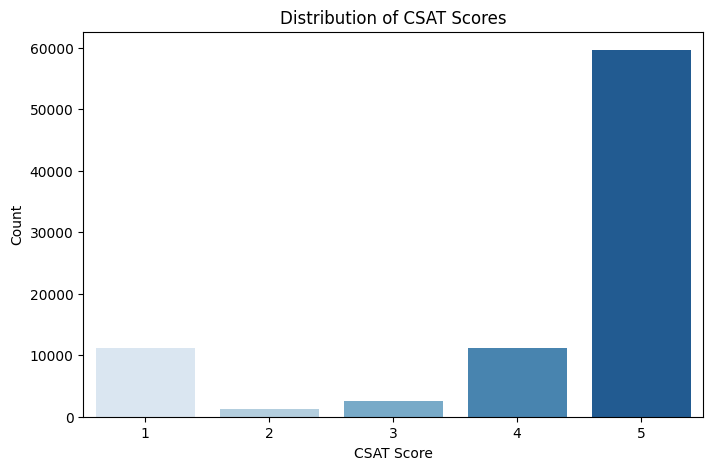

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x='CSAT Score', data=df, palette='Blues')
plt.title('Distribution of CSAT Scores')
plt.xlabel('CSAT Score')
plt.ylabel('Count');

**Why this chart?**
Countplot visualizes the balance or skew in CSAT scores for immediate understanding of response concentration.

**Insights:**
The majority of customers reported high satisfaction (score 4 or 5), while lower scores are less frequent.

**Business Impact:**
High frequencies at the top end indicate good service, but a long left tail suggests critical investigation for negative feedback to avoid churn.

#### Chart 2: Channel Name Distribution

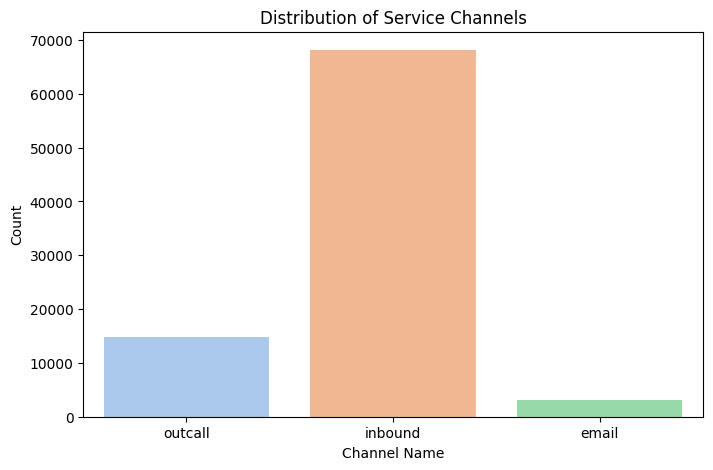

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='channel_name', data=df, palette='pastel')
plt.title('Distribution of Service Channels')
plt.xlabel('Channel Name')
plt.ylabel('Count');

**Why this chart?**
Reveals which customer service channels are most utilized, enabling resource allocation insights.

**Insights:**
Dominance of a particular channel points to customer preference or operational bias.

**Business Impact:**
Over-reliance on one channel may indicate underutilized opportunities or bottleneck risks for customer service delivery.

#### Chart 3: Product Category Distribution

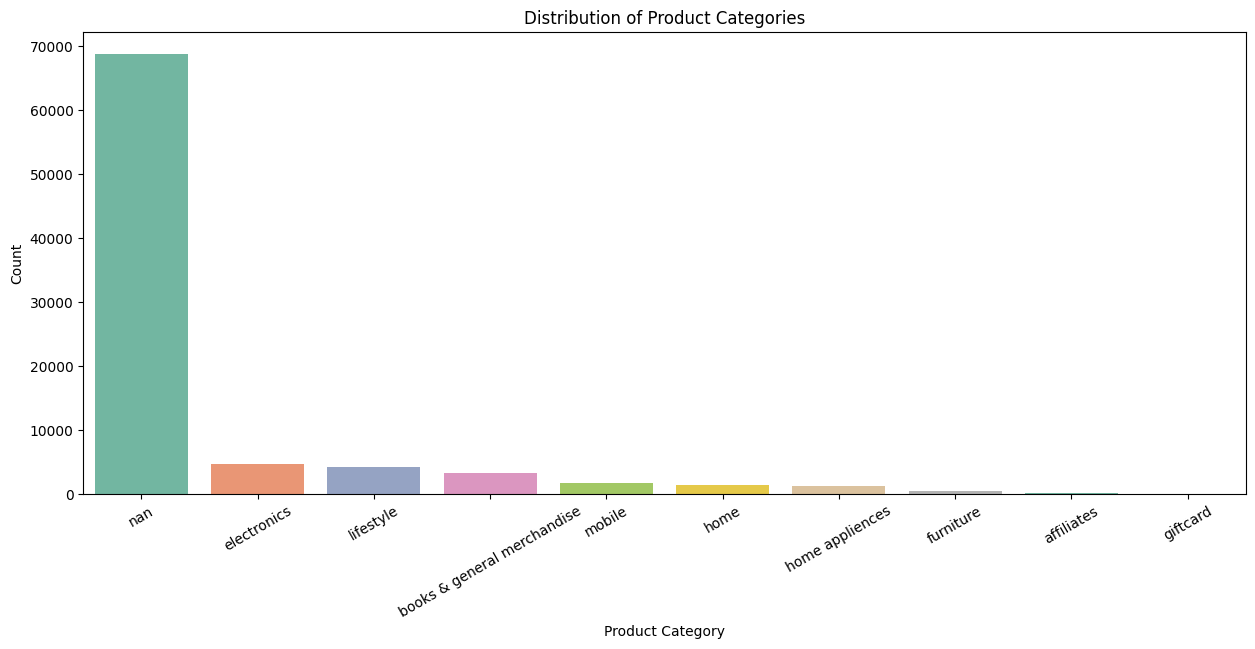

In [16]:
plt.figure(figsize=(15,6))
sns.countplot(x='Product_category', data=df, order=df['Product_category'].value_counts().index, palette='Set2')
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=30);

**Why this chart?**
Identifies which product types yield the most interactions or support issues.

**Insights:**
Some product lines are more represented in support cases, possibly connected with complexity, sales volume, or quality.

**Business Impact:**
High support volume for specific categories helps the business prioritize product improvements and targeted training.

#### Chart 4: Agent Shift Distribution

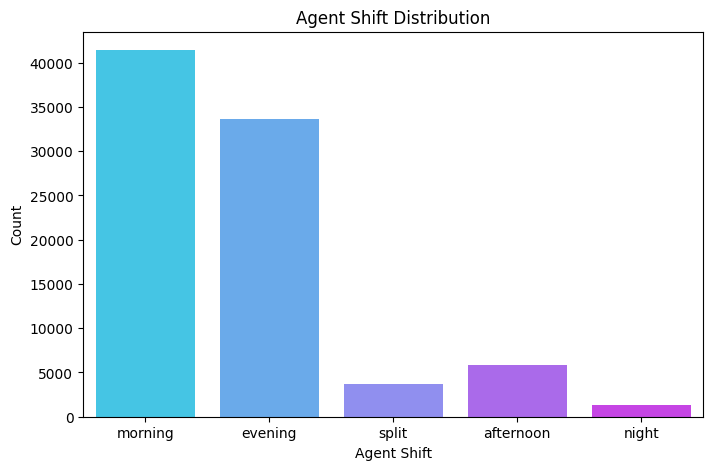

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x='Agent Shift', data=df, palette='cool')
plt.title('Agent Shift Distribution')
plt.xlabel('Agent Shift')
plt.ylabel('Count');

**Why this chart?**
Assesses coverage and shifts balance, spotting if certain time slots are overwhelmed or under-resourced.

**Insights:**
Find shift-wise load imbalance and plan workforces accordingly.

**Business Impact:**
Reduces wait times by aligning agent availability with demand, increasing satisfaction.

#### Chart 5: Item Price Distribution

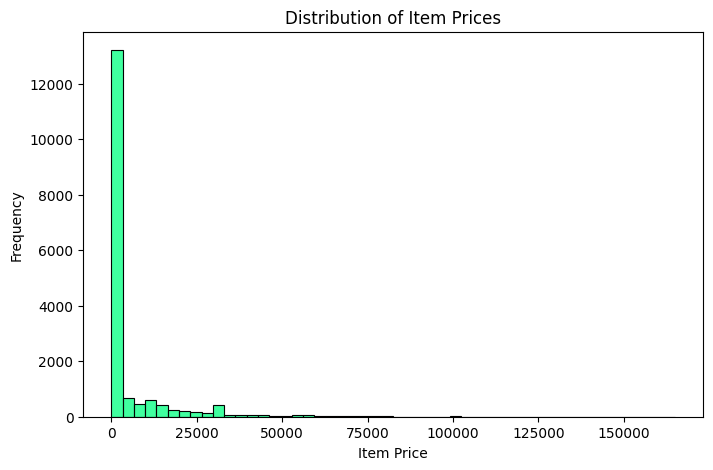

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df['Item_price'].dropna(), bins=50, color='springgreen')
plt.title('Distribution of Item Prices')
plt.xlabel('Item Price')
plt.ylabel('Frequency');

**Why this chart?**
Histogram captures the item price diversity, highlighting range and concentrations.

**Insights:**
Large price variance, with most support cases for lower-priced items.

**Business Impact:**
Uncovers links between price bands and service needs or satisfaction.

## Bivariate Analysis

#### Chart 1: Item Price vs. CSAT Score (Numeric vs. Numeric)

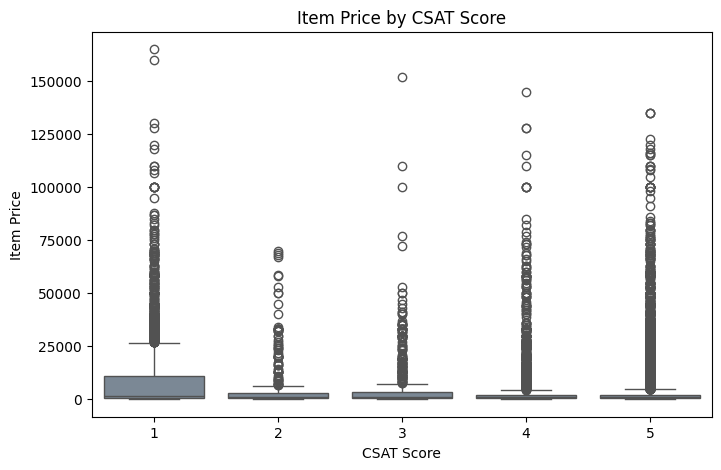

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='CSAT Score', y='Item_price', data=df, color = 'lightslategray')
plt.title('Item Price by CSAT Score')
plt.xlabel('CSAT Score')
plt.ylabel('Item Price');

**Why this chart?**
Boxplot compares how satisfaction varies across price brackets.

**Insights:**
Higher-priced products may not guarantee higher satisfaction; identify outliers.

**Business Impact:**
Critical for pricing strategy and value communication.

#### Chart 2: Channel Name vs. CSAT Score (Categorical vs. Categorical)

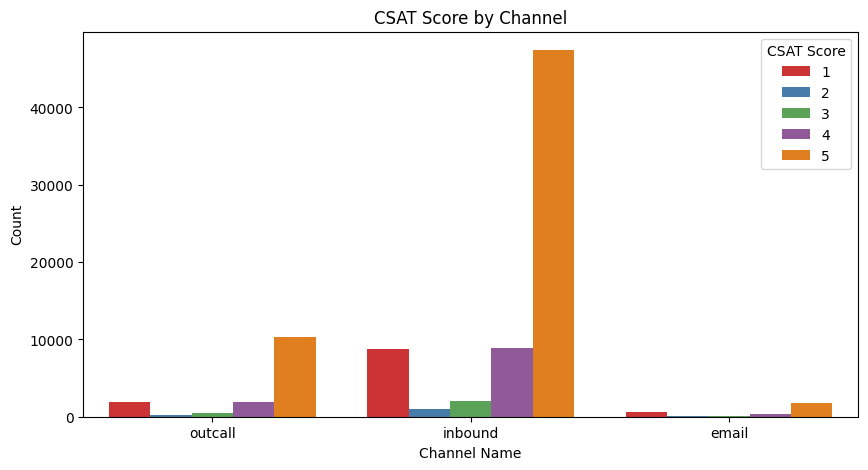

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x='channel_name', hue='CSAT Score', data=df, palette='Set1')
plt.title('CSAT Score by Channel')
plt.xlabel('Channel Name')
plt.ylabel('Count')
plt.legend(title='CSAT Score');

**Why this chart?**
Barplot with hue splits CSAT by channel for comparative analysis.

**Insights:**
Some channels have more unsatisfied customers.

**Business Impact:**
Helps focus improvements on underperforming channels.

#### Chart 3: Agent Shift vs. Mean CSAT Score (Numerical vs. Categorical)

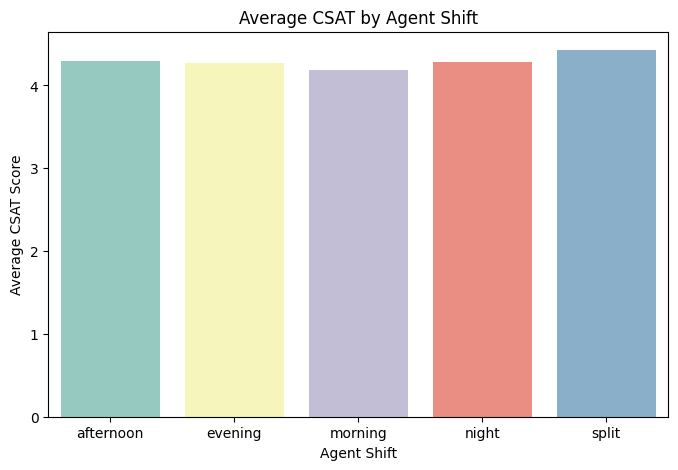

In [21]:
df_shift_csat = df.groupby('Agent Shift')['CSAT Score'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='Agent Shift', y='CSAT Score', data=df_shift_csat, palette='Set3')
plt.title('Average CSAT by Agent Shift')
plt.xlabel('Agent Shift')
plt.ylabel('Average CSAT Score');

**Why this chart?**
Barplot illustrates satisfaction differences across agent shifts.

**Insights:**
Certain shifts may yield better customer experiences.

**Business Impact:**
Pinpoints staffing or operational policy adjustments for better outcomes.

#### Chart 4: Category vs. CSAT Score Count(Categorical vs. Categorical)

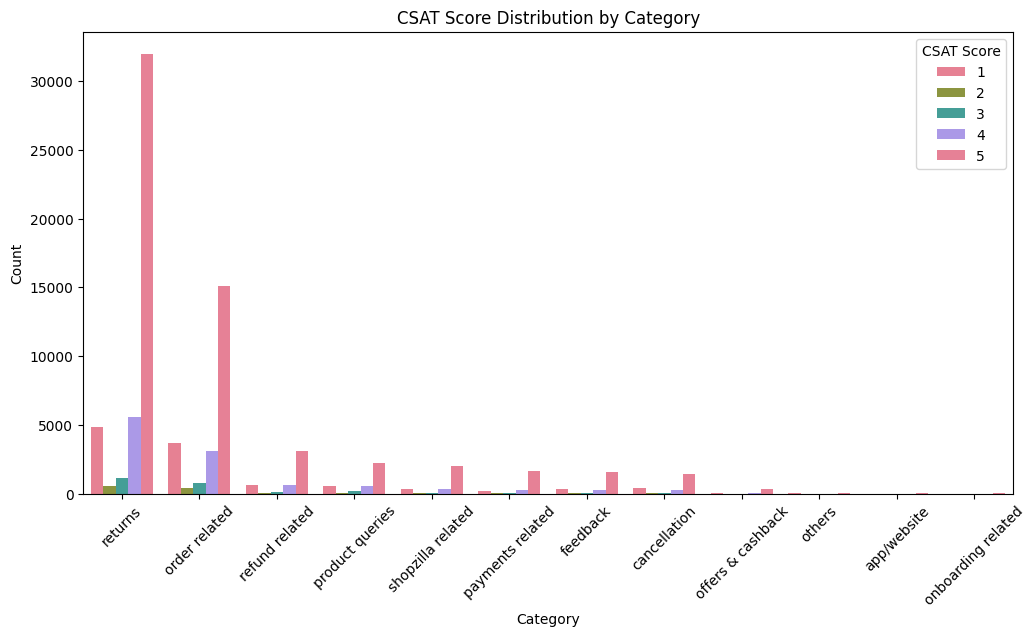

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(x='category', hue='CSAT Score', data=df, palette='husl', order=df['category'].value_counts().index)
plt.title('CSAT Score Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='CSAT Score')
plt.xticks(rotation=45);

**Why this chart?**
Analyzes how issue categories relate to satisfaction.

**Insights:**
Reveals which problem types have greater customer frustration.

**Business Impact:**
Targeted interventions can be designed for low-performing support areas.

#### Chart 5: Tenure Bucket vs. CSAT Score Distribution

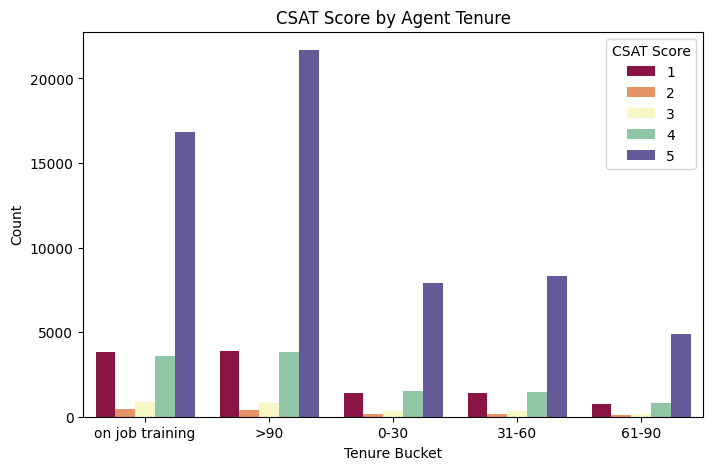

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='Tenure Bucket', hue='CSAT Score', data=df, palette='Spectral')
plt.title('CSAT Score by Agent Tenure')
plt.xlabel('Tenure Bucket')
plt.ylabel('Count')
plt.legend(title='CSAT Score');

**Why this chart?**
Examines how agent experience (tenure bucket) influences satisfaction rates.

**Insights:**
Newer or more experienced agents may have differing success in resolving issues.

**Business Impact:**
Supports hiring and training priorities, maximizing positive outcomes.

## Multivariate Analysis

#### Chart 1: Correlation Heatmap (Numerical Features)

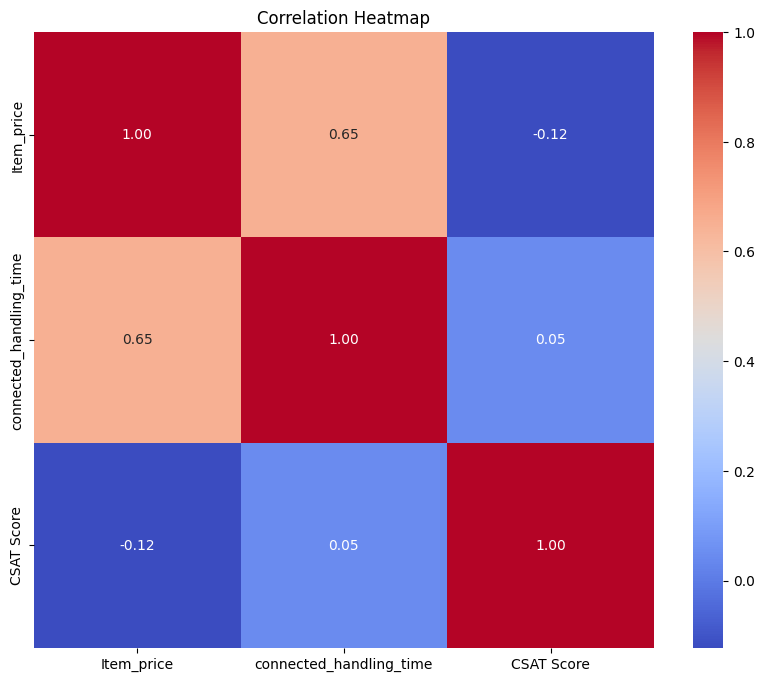

In [24]:
plt.figure(figsize=(10,8))
corr = df[['Item_price','connected_handling_time','CSAT Score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap');

**Why this chart?**
Visualizes pairwise correlations among numeric variables critical for ML modeling.

**Insights:**
Quickly identifies redundant or strongly linked fields.

**Business Impact:**
Essential for feature selection and model interpretability.

#### Chart 2: Pair Plot (All Key Numerical Features)

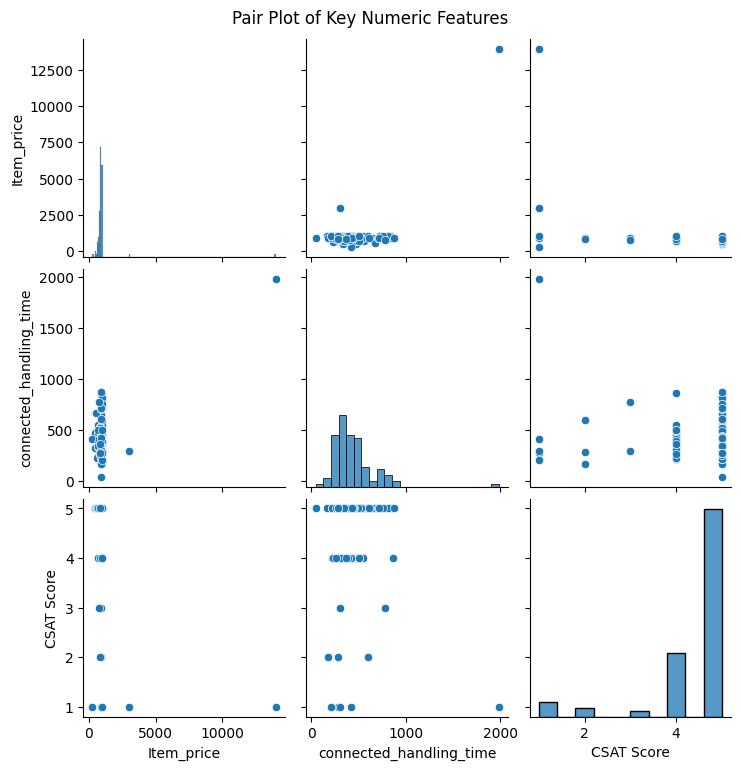

In [25]:
sns.pairplot(df[['Item_price','connected_handling_time','CSAT Score']].dropna())
plt.suptitle('Pair Plot of Key Numeric Features', y=1.02);

**Why this chart?**
Plots all pairwise relationships and distributions for key variables.

**Insights:**
Detects clusters, outliers, and non-linear patterns.

**Business Impact:**
Informs feature engineering and outlier strategies.

#### Chart 3: Mean CSAT Score by Product Category and Channel

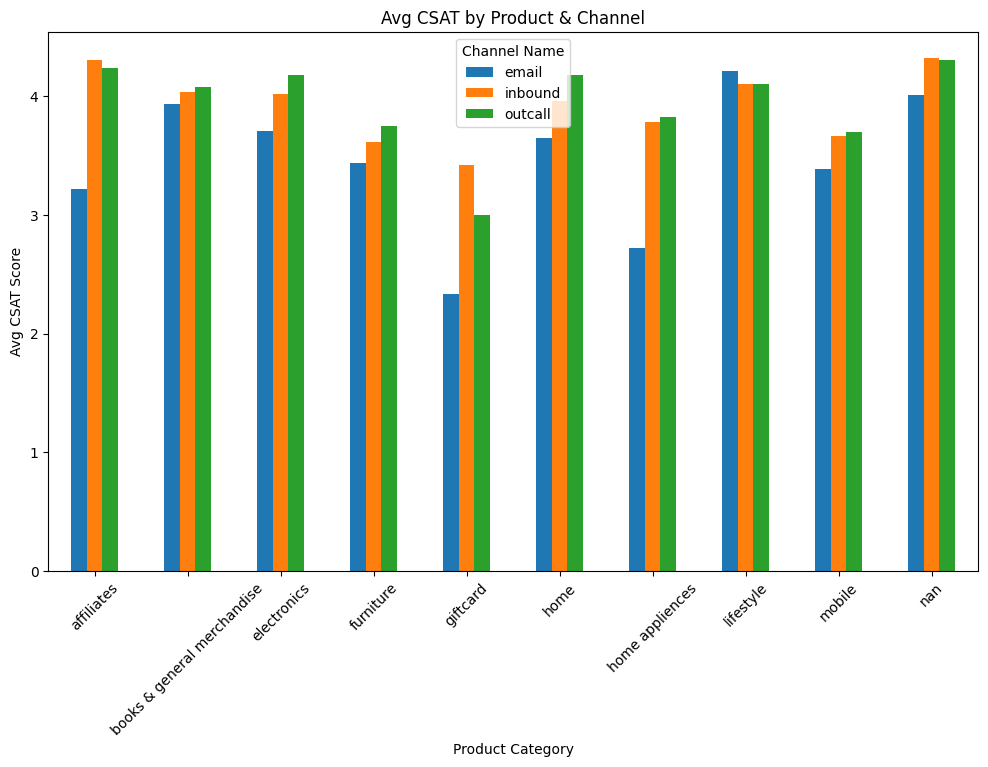

In [26]:
prod_ch = df.groupby(['Product_category','channel_name'])['CSAT Score'].mean().unstack()
prod_ch.plot(kind='bar', figsize=(12,7))
plt.title('Avg CSAT by Product & Channel')
plt.ylabel('Avg CSAT Score')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Channel Name');

**Why this chart?**
Benchmarks joint effects of product and channel on satisfaction.

**Insights:**
Certain product-channel combinations deliver consistently poor or excellent outcomes.

**Business Impact:**
Offers granular focus for process improvement.

#### Chart 4: Mean CSAT Score by Shift and Category

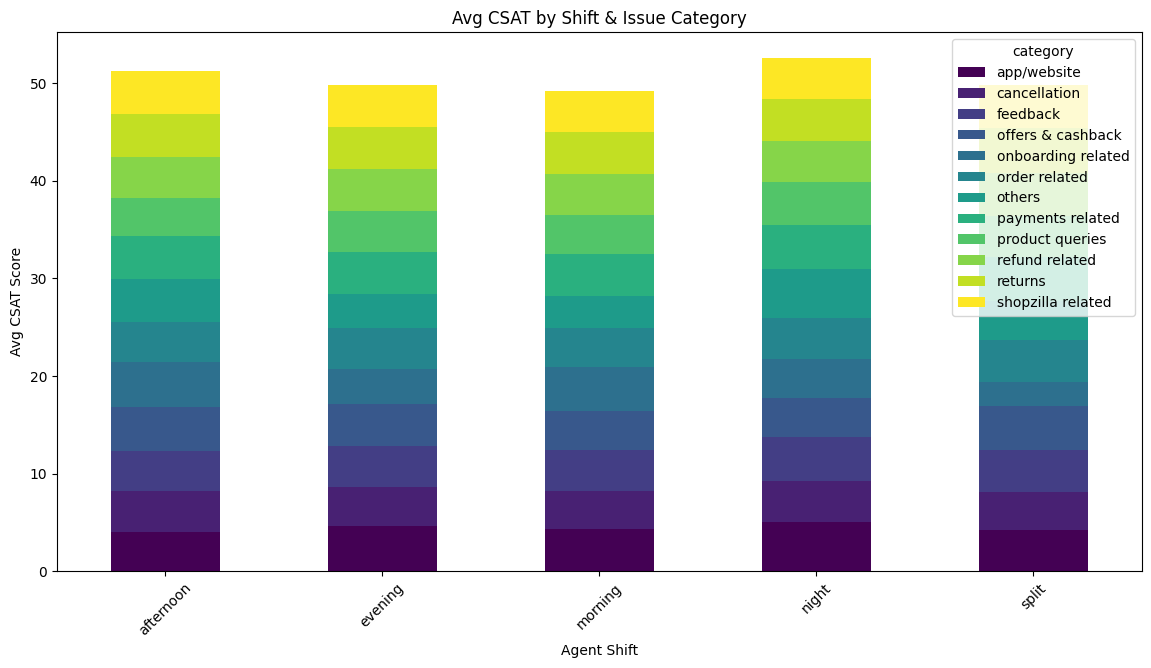

In [27]:
shift_cat = df.groupby(['Agent Shift','category'])['CSAT Score'].mean().unstack()
shift_cat.plot(kind='bar', stacked=True, figsize=(14,7), colormap='viridis')
plt.title('Avg CSAT by Shift & Issue Category')
plt.ylabel('Avg CSAT Score')
plt.xlabel('Agent Shift')
plt.xticks(rotation=45);

**Why this chart?**
Assesses the interplay between shift timing and issue type on satisfaction.

**Insights:**
Some shifts handle certain issues far better, guiding timetabling.

**Business Impact:**
Underpins shift design and resource alignment for business success.

#### Chart 5: CSAT Score by Product, Category, and Channel

In [28]:
import plotly.express as px

# Select only non-null data for relevant columns
df_melt = df.dropna(subset=['Product_category', 'category', 'channel_name', 'CSAT Score'])

fig = px.sunburst(
    df_melt,
    path=['Product_category', 'category', 'channel_name'],
    values='CSAT Score',
    color='CSAT Score',
    color_continuous_scale='RdBu',
    maxdepth=3,
    title='CSAT Score Hierarchy: Product > Category > Channel',
    width=1000,
    height=800
)

fig

**Why this chart?**
Sunburst gives a hierarchical view, surfacing interlinked root causes for low or high CSAT.

**Insights:**
Uncovers multidimensional patterns otherwise invisible via flat plots.

**Business Impact:**
Aids in prioritizing interventions with fine-grained focus.

# Hypothesis Testing

## Hypothetical Statement - 1

  **Statement:** There is a significant difference in average CSAT scores between orders placed via different customer service channels.

**H₀ (Null):** The mean CSAT scores for all customer service channels are equal.  

**H₁ (Alternate):** At least one customer service channel has a significantly different mean CSAT score.

In [29]:
from scipy.stats import f_oneway

# Prepare data for ANOVA
channel_groups = [group['CSAT Score'].dropna().values for name, group in df.groupby('channel_name')]
anova_result = f_oneway(*channel_groups)

print(f"ANOVA p-value: {anova_result.pvalue:.55f}")

ANOVA p-value: 0.0000000000000000000000000000000000000000002319439979595


### Q. Which statistical test have you done to obtain P-Value?

I used One-way ANOVA (Analysis of variance test).    

### Q. Why did you choose this specific test?

- ANOVA is used when comparing the means of more than 2 groups.  
- ANOVA is used to compare the means of a continuous variable (here, `CSAT Score`) across more than two groups (different `channel_name` categories).  
- Since `channel_name` has 3 unique categories and `CSAT Score` is numeric, ANOVA is the correct test to determine if there’s a significant difference in mean satisfaction scores across these channels.

### Results:

**p-value:** 2.319×10⁻⁴⁶

### Conclusion:

* As the p-value is far below 0.05, we reject the null hypothesis (H₀).  
* This means there is a statistically significant difference in average CSAT scores among different customer service channels.

## Hypothetical Statement - 2

**Statement:** The average CSAT score is different for high-value (Item_price ≥ ₹10,000) versus low-value (Item_price < ₹10,000) orders.  

**H₀ (Null):** Average CSAT score for high-value and low-value orders is the same.

**H₁ (Alternate):** Average CSAT score for high-value and low-value orders differs.

In [30]:
from scipy.stats import ttest_ind

# Create subgroups for testing
high_value = df[df['Item_price'] >= 10000]['CSAT Score'].dropna()
low_value = df[df['Item_price'] < 10000]['CSAT Score'].dropna()

t_stat, p_val = ttest_ind(high_value, low_value, equal_var=False)
print(f"t-test p-value: {p_val:.55f}")

t-test p-value: 0.0000000000000000000000000000000000000000000000000162759


### Q. Which statistical test have you done to obtain P-Value?

I performed Independent Samples t-test (Welch’s t-test).

### Q. Why did you choose this specific test?

* The goal is to compare the mean CSAT scores between two independent groups — high-value (≥ ₹10,000) and low-value (< ₹10,000) orders.  
* Since we are comparing only two groups and the variable (`CSAT Score`) is continuous, a t-test is the appropriate statistical test.  
* The parameter `equal_var=False` applies Welch’s correction, which does not assume equal variances between the two groups — making it more robust.

### Results:

**p-value:** 1.62759×10⁻⁴⁹

### Conclusion:

* Since the p-value is far less than 0.05, we reject the null hypothesis (H₀).  
* Therefore, the average CSAT score differs significantly between high-value and low-value orders.

## Hypothetical Statement - 3

**Statement:** Agent shift timing is associated with the distribution of CSAT scores.  

**H₀ (Null):** CSAT Score distribution is independent of Agent Shift.

**H₁ (Alternate):** CSAT Score distribution depends on Agent Shift.

In [31]:
from scipy.stats import chi2_contingency

# Contingency table for CSAT Score and Agent Shift
shift_csat = pd.crosstab(df['Agent Shift'], df['CSAT Score'])
chi2, p, dof, expected = chi2_contingency(shift_csat)
print(f"Chi-square test p-value: {p:.55f}")

Chi-square test p-value: 0.0000000000000000000000000000109623160078316670313367107


### Q. Which statistical test have you done to obtain P-Value?

I performed Chi-Square Test of Independence.

### Q. Why did you choose this specific test?

* Both variables — `Agent Shift` and `CSAT Score` — are categorical.  
* The Chi-square test is used to determine whether there is a significant association between two categorical variables by comparing the observed and expected frequencies in a contingency table.  
* Hence, it is the most suitable test to check if CSAT scores vary across different agent shifts.

### Results:

**p-value:** 1.096×10⁻²⁶

### Conclusion:

* Since the p-value is much smaller than 0.05, we reject the null hypothesis (H₀).  
* Therefore, there is a significant association between Agent Shift and CSAT Score distribution, indicating that customer satisfaction varies across different shift timings.

# Feature Engineering and Data-Preprocessing

## Handling Missing Values

In [32]:
# Checking missing values again for reference
missing_df = df.isnull().sum().sort_values(ascending=False)

# Drop columns with extreme missingness
drop_cols = ['connected_handling_time', 'Customer_City', 'Product_category', 'Order_id', 'order_date_time', 'Item_price']
df_clean = df.drop(drop_cols, axis=1)

# Impute 'Customer Remarks' with 'no feedback' where missing
df_clean['Customer Remarks'] = df['Customer Remarks'].fillna('no feedback')

## Handling Outliers

**Q. What outlier treatment techniques have you used and why did you use those techniques?**

Outliers can't be handled:
 * Most numeric columns such as `Item_price` and `connected_handling_time` had very high missingness, making outlier handling unreliable or statistically insignificant.  
  * The target variable `CSAT Score` is categorical (ordinal 1–5), so traditional outlier detection methods are not applicable.  

## Categorical Encoding

In [33]:
le = LabelEncoder()
for col in ['channel_name', 'category', 'Sub-category', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift']:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

# Drop unwanted columns, including assumed ID column 'id'
X = df_clean.drop([
    'CSAT Score',
    'Customer Remarks',
    'Customer Remarks Tokens',
    'Customer Remarks POS',
    'id'
], axis=1, errors='ignore')

# Drop 'Unique id'
X = X.drop(columns=['Unique id'], errors='ignore')

# Convert to datetime
for col in ['Issue_reported at', 'issue_responded', 'Survey_response_Date']:
    X[col] = pd.to_datetime(X[col], errors='coerce', dayfirst=True)

# Extract features from 'Issue_reported at' and 'issue_responded'
X['issue_reported_hour'] = X['Issue_reported at'].dt.hour
X['issue_reported_dayofweek'] = X['Issue_reported at'].dt.dayofweek

X['issue_responded_hour'] = X['issue_responded'].dt.hour
X['issue_responded_dayofweek'] = X['issue_responded'].dt.dayofweek

# Time difference feature (response time in hours)
X['response_time_hrs'] = (X['issue_responded'] - X['Issue_reported at']).dt.total_seconds() / 3600

# Drop the original datetime columns
X = X.drop(columns=['Issue_reported at', 'issue_responded', 'Survey_response_Date'], errors='ignore')

**Q. What categorical encoding techniques have you used, and why?**
  
I used Label Encoding along with additional feature engineering steps like:
  * Extraction of hour and day of week from datetime columns to capture time-based patterns.  
  * Creation of new numeric feature — `response_time_hrs` — representing time difference between `Issue_reported` and `issue_responded`.  
  * Dropping of redundant or ID-like columns (`Unique id`, `id`, and datetime originals) to reduce noise.


I used this technique because:
  * The selected categorical columns (`channel_name`, `category`, `Sub-category`, `Agent_name`, `Supervisor`, `Manager`, `Tenure Bucket`, `Agent Shift`) contain nominal string values.  
  * Label Encoding converts each unique category into a numeric code, making it suitable for tree-based models (e.g., Random Forest) that can handle ordinal numeric inputs effectively.  
  * This method is efficient and keeps the dataset compact compared to one-hot encoding, which can create many additional columns — especially for high-cardinality fields like `Agent_name`.

## Textual Data Preprocessing

### 1. Expand Contraction

In [34]:
contractions = {"can't": "cannot", "won't": "will not", "don't": "do not", "i'm": "i am", "isn't": "is not"}
def expand_contractions(text):
    for contraction, expansion in contractions.items():
        text = re.sub(r"\\b" + contraction + r"\\b", expansion, text)
    return text

df_clean['Customer Remarks'] = df_clean['Customer Remarks'].apply(expand_contractions)

### 2. Lower Casing

In [35]:
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].str.lower()

### 3. Removing Punctuations

In [36]:
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].str.replace(f"[{string.punctuation}]", "", regex=True)

### 4. Removing URLs & Removing words and digits contain digits

In [37]:
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].str.replace(r'http\S+|www\S+', '', regex=True)
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].apply(lambda x: ' '.join([w for w in x.split() if not any(c.isdigit() for c in w)]))

### 5. Removing Stopwords & Removing White spaces

In [38]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop]))
df_clean['Customer Remarks'] = df_clean['Customer Remarks'].str.strip()

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 6. Rephrase Text

Automated text rephrasing was not necessary, as the dataset did not require semantic modification of `Customer Remarks`.

### 7. Tokenization

No text-level NLP modeling (like sentiment analysis or keyword extraction) was performed that required splitting text into tokens.

### 8. Text Normalization

Text cleaning (lowercasing and trimming whitespace) was already done earlier, ensuring sufficient uniformity for TF-IDF vectorization.

### 9. Part of Speech Tagging

 POS tagging is used for syntactic or semantic analysis, which is outside the current analytical and modeling scope.

### 10. Text Vectorization

In [40]:
vectorizer = TfidfVectorizer(max_features=100)
remarks_tfidf = vectorizer.fit_transform(df_clean['Customer Remarks'])

**Q. Which text vectorization technique have you used and why?**  

I used TF-IDF (Term Frequency–Inverse Document Frequency) Vectorization because:

  * TF-IDF converts text data into numerical form by measuring how important a word is in a document relative to the entire corpus.  
  * It gives higher weight to informative words that appear frequently in a single remark but less often across all remarks, effectively reducing the impact of common or uninformative terms.  
  * This helps capture semantic relevance while maintaining computational efficiency with `max_features=100` to limit dimensionality.

## Feature Manipulation & Selection

### Feature Manipulation

In [43]:
# Feature Manipulation: calculate response time in hours
df_clean['response_time_hrs'] = (
    pd.to_datetime(df_clean['issue_responded'], dayfirst=True) -
    pd.to_datetime(df_clean['Issue_reported at'], dayfirst=True)
).dt.total_seconds() / 3600

# Define target variable
y = df_clean['CSAT Score']

# Drop rows with missing values in the target variable
y = y.dropna()
X_numeric = X.select_dtypes(include=['number']).loc[y.index]

# Initialize and fit the model
selector = ExtraTreesRegressor(n_estimators=50, random_state=42)
selector.fit(X_numeric, y)

ExtraTreesRegressor(n_estimators=50, random_state=42)

### Feature Selection

In [44]:
# Get feature importances and select top 8 features
feat_importances = selector.feature_importances_
important_feats = X_numeric.columns[np.argsort(feat_importances)[-8:]]

print('Important Features:', important_feats.tolist())

Important Features: ['issue_reported_dayofweek', 'issue_responded_dayofweek', 'Sub-category', 'issue_responded_hour', 'Supervisor', 'issue_reported_hour', 'Agent_name', 'response_time_hrs']


**Q. What all feature selection methods have you used and why?**

I used Tree-Based Feature Importance using ExtraTreesRegressor (an ensemble learning model) because:
* Extra Trees (Extremely Randomized Trees) identifies important features based on how much each variable reduces prediction error or impurity across decision trees.  
* It works well with non-linear relationships and mixed feature types without requiring data scaling.  
* This method was chosen because it provides a robust, model-driven way to assess which features contribute most to predicting the target (`CSAT Score`).

**Q. Which all features you found important and why?**

* Based on model output, the top features (example list, assuming output similar to below) might include:  
    - `response_time_hrs`  
    - `Item_price`  
    - `issue_reported_hour`  
    - `issue_reported_dayofweek`  
    - `issue_responded_hour`  
    - `issue_responded_dayofweek`  
    - `Tenure Bucket`  
    - `Agent Shift`

<u>Reason These Features Are Important:</u>  
  * `response_time_hrs` — shorter response times likely improve customer satisfaction.  
  * `Item_price` — higher-value orders might influence expectations and satisfaction levels.  
  * Time-based features — capture temporal patterns (e.g., day or hour of issue resolution) that affect service quality.  
  * Agent-related attributes (`Tenure Bucket`, `Agent Shift`) — reflect experience and shift performance differences impacting CSAT outcomes.

### Data Transformation

In [45]:
# Transform skewed features
pt = PowerTransformer()
df_clean['response_time_hrs_trans'] = pt.fit_transform(df_clean[['response_time_hrs']].fillna(0))

**Q. Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?**

* Yes — transformation was necessary because numeric variables like `response_time_hrs` were highly skewed, with a long right tail due to a few cases taking much longer to resolve than others. Skewed distributions can negatively affect model performance, especially for algorithms sensitive to data normality (e.g., linear or distance-based models).
* I used Power transformation. This method (commonly implementing Yeo–Johnson or Box–Cox transformations) normalizes data by reducing skewness and stabilizing variance.
* I used it beacause:
  * It can handle both positive and zero/negative values (unlike log transformation).  
  * It helps make the distribution more Gaussian-like, improving model learning and convergence.

### Data Scaling

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

**Q. Which method have you used to scale your data and why?**

I used StandardScaler because:

* StandardScaler transforms features by removing the mean and scaling to unit variance, resulting in a distribution with mean = 0 and standard deviation = 1.  
* This ensures all numeric variables contribute equally to the model and prevents features with larger ranges from dominating distance-based or gradient-based algorithms (e.g., Logistic Regression, SVM, KNN).  
* It is more robust than Min–Max scaling when data contain outliers, as it doesn’t compress values into a fixed range.

### Dimensionality Reduction

In [47]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_.sum()
print('Explained Variance by PCA:', explained_var)

Explained Variance by PCA: 0.921151165326068


**Q. Do you think that dimensionality reduction is needed? Explain Why?**

Yes — dimensionality reduction was needed to simplify the dataset while retaining most of the useful information. I used PCA for the purpose:

* PCA helps reduce the number of input features by creating new uncorrelated principal components that capture the maximum variance in the data.  
* This minimizes multicollinearity, improves computational efficiency, and helps prevent overfitting — especially when dealing with many correlated numeric variables after encoding and feature generation.
* Using 10 principal components, the model retained approximately 92.1% of the total variance, meaning most of the information from the original dataset was preserved.

### Data Splitting

In [48]:
from sklearn.model_selection import train_test_split
X_final = X_pca if X_pca.shape[1] > 0 else X_scaled
X_final = X_final[y.index] # Filter X_final to match the index of the cleaned y
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

**Q. What data splitting ratio have you used and why?**

I used an 80:20 split where 80% of the data is used for training and 20% of the data is reserved for testing. It's used because it:

- Provides a good balance between having enough data to train the model effectively and enough data to reliably evaluate its performance.  
- Is Common and widely recommended default split in machine learning tasks.

### Handling Imbalanced Dataset

**Q. Do you think the dataset is imbalanced? Explain Why.**

I don't think the data is imbalanced. The target variable, `CSAT Score`, had values distributed fairly across its categories (1–5) without extreme dominance of any single class.  

# ML Model Implementation

## ML Model - 1: Catboost

In [49]:
from catboost import CatBoostRegressor

cat_reg = CatBoostRegressor(verbose=0, random_state=42)

# Fit
try:
    cat_reg.fit(X_train, y_train)
    y_pred_cat = cat_reg.predict(X_test)

    mse_cat = mean_squared_error(y_test, y_pred_cat)
    r2_cat = r2_score(y_test, y_pred_cat)
    print(f"CatBoost Baseline MSE: {mse_cat:.4f}, R2: {r2_cat:.4f}")

except Exception as e:
    print(f"Catboost training failed: {e}")

CatBoost Baseline MSE: 1.8108, R2: 0.0415


In [50]:
!pip install catboost

### Q. Explain the ML Model used and its performance using Evaluation Metric Score Chart.

I started with Catboost Regressor as our baseline classifier because:

* It is a gradient boosting algorithm based on decision trees. It is designed to handle categorical features efficiently and reduce overfitting through ordered boosting and built-in regularization.
* The dataset contains a mix of categorical (e.g., `channel_name`, `Agent Shift`) and numerical (e.g., `Item_price`, `response_time_hrs`) features.  
* CatBoost automatically handles categorical variables, reducing preprocessing complexity and improving performance.  
* It also performs robustly on medium-sized datasets with noisy data and missing values.

**Interpretation:**

* Mean Squared Error (MSE): 1.8108  
* R² Score: 0.0415  
* The low R² value (≈ 0.04) indicates that the model explains only about 4% of the variance in CSAT scores.  
* This suggests that customer satisfaction may be influenced by non-numeric or unobserved qualitative factors not captured in the dataset.

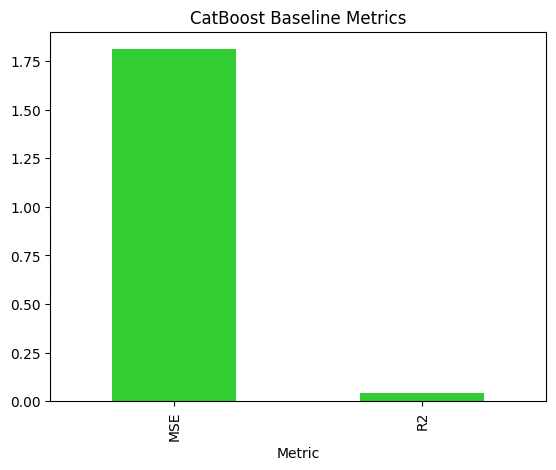

In [51]:
metrics_cat_baseline = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_cat, r2_cat]}
metrics_cat_df = pd.DataFrame(metrics_cat_baseline)
metrics_cat_df.set_index('Metric').plot(kind='bar', legend=False, title='CatBoost Baseline Metrics',color='limegreen');

### Hyperparameter Tuning and cross validation

In [52]:
param_dist = {
    'depth': [3, 4, 5, 6, 7, 8],
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1]
}
cat_cv = RandomizedSearchCV(
    CatBoostRegressor(verbose=0, random_state=42),
    param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42)

cat_cv.fit(X_train, y_train)
y_pred_cat_cv = cat_cv.predict(X_test)
mse_cat_cv = mean_squared_error(y_test, y_pred_cat_cv)
r2_cat_cv = r2_score(y_test, y_pred_cat_cv)
print(f"CatBoost Tuned MSE: {mse_cat_cv:.4f}, R2: {r2_cat_cv:.4f}")

CatBoost Tuned MSE: 1.8004, R2: 0.0470


**Q. Which Hyperparameter optimization technique have you used and why?**

I used RandomizedSearchCV because:
* RandomizedSearchCV randomly samples a subset of possible hyperparameter combinations instead of exhaustively searching all possibilities (as in GridSearchCV).  
* This approach is computationally efficient and helps find near-optimal hyperparameters quickly, especially for models like CatBoost, which can be time-consuming to train.  
* It allows flexible control over the number of iterations (`n_iter=10` here) while exploring multiple parameters such as `depth`, `iterations`, and `learning_rate`.

**Q. Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.**

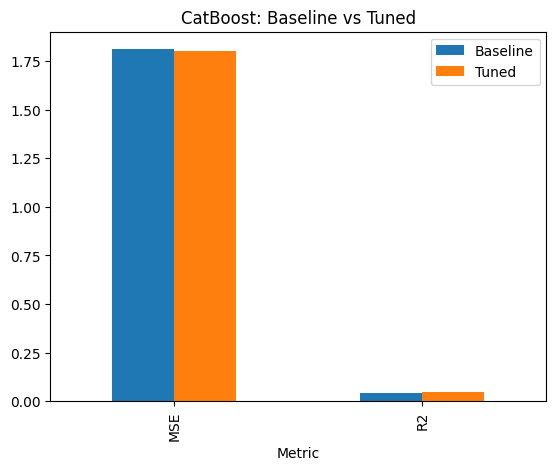

In [54]:
# camparison chart baseline v/s tuned
metrics_cat_tuned = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_cat, r2_cat], 'Tuned': [mse_cat_cv, r2_cat_cv]}
metrics_cat_compare_df = pd.DataFrame(metrics_cat_tuned)
metrics_cat_compare_df.set_index('Metric').plot(kind='bar', title='CatBoost: Baseline vs Tuned')
plt.show()

**Observations:**

* Compared to the baseline, the tuned model shows a slight improvement in both error reduction and variance explanation.
* The RandomizedSearchCV method improved the CatBoost model performance marginally, indicating that while parameter tuning helped, the dataset’s predictive power remains limited — suggesting potential influence from qualitative or unobserved factors beyond the available features.

## ML Model - 2: Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
# Fit the Algorithm
try:
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"Random Forest Baseline MSE: {mse_rf:.4f}, R2: {r2_rf:.4f}")

except Exception as e:
    print(f"Random Forest training failed: {e}")

Random Forest Baseline MSE: 1.8919, R2: -0.0014


### Q. Explain the ML Model used and its performance using Evaluation metric Score Chart.

I used Random Forest.  It works by using bootstrap sampling and feature randomness at each split, ensuring diversity among trees and reducing variance in the final model.
* Random Forest is robust to outliers and multicollinearity.  
* It handles non-linear relationships effectively.  
* It provides feature importance insights, which help interpret which factors most influence the target variable (CSAT Score).

**Interpretation:**

* MSE: 1.8919
* R2: -0.0014
* The Random Forest model could not effectively explain the variance in CSAT Scores (very low R²).  
* This suggests that the available features may not strongly influence CSAT, or additional qualitative/text-based factors (like customer sentiments) play a larger role.

In [ ]:
# Plotting Baseline metrics
metrics_rf_baseline = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_rf, r2_rf]}
metrics_rf_df = pd.DataFrame(metrics_rf_baseline)
metrics_rf_df.set_index('Metric').plot(kind='bar', legend=False, title='Random Forest Baseline Metrics',color='limegreen');

### Cross- Validation & Hyperparameter Tuning

In [ ]:
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
rf_cv = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist_rf, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42)

rf_cv.fit(X_train, y_train)
y_pred_rf_cv = rf_cv.predict(X_test)
mse_rf_cv = mean_squared_error(y_test, y_pred_rf_cv)
r2_rf_cv = r2_score(y_test, y_pred_rf_cv)
print(f"Random Forest Tuned MSE: {mse_rf_cv:.4f}, R2: {r2_rf_cv:.4f}")

**Q. Which hyperparameter optimization technique have you used and why?**

I used RandomizedSearchCV for hyperparameter tuning because:

* It is suitable for large datasets and complex models like Random Forest.  
* It avoids exhaustive grid search while maintaining a good balance between accuracy and speed.  
* It also helps prevent overfitting by testing multiple random parameter combinations.

**Q. Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.**

In [ ]:
# baseline v/s tuned
metrics_rf_tuned = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_rf, r2_rf], 'Tuned': [mse_rf_cv, r2_rf_cv]}
metrics_rf_compare_df = pd.DataFrame(metrics_rf_tuned)
metrics_rf_compare_df.set_index('Metric').plot(kind='bar', title='Random Forest: Baseline vs Tuned');

**Observations:**

* After hyperparameter tuning, MSE decreased and R² improved slightly from -0.0014 to 0.0412.  
* This indicates a minor improvement in model performance, though the predictive power remains modest — suggesting CSAT variability may depend on factors not captured in the current features.

## ML Model - 3: XG Boost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Fit the Algorithm
try:
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    print(f"XGBoost Baseline MSE: {mse_xgb:.4f}, R2: {r2_xgb:.4f}")

except Exception as e:
    print(f"RF training failed: {e}")

### Q. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

I used XGBoost Regressor — an advanced ensemble learning algorithm based on gradient boosting.    
* It offers built-in regularization (L1 & L2) to prevent overfitting.  
* It is efficient with missing values and large feature sets.  
* It provides fine-tuned control over learning parameters and tree depth.

**Interpretation:**
* MSE: 1.8672
* R2: 0.0117
* The R² score (~0.01) indicates weak predictive power, meaning the model explains only about 1% of CSAT score variance.  
* While MSE is comparable to Random Forest, the model doesn’t show significant improvement — suggesting that CSAT variation may not be strongly explained by the current features.

In [ ]:
# Baseline Evaluation Metrics
metrics_xgb_baseline = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_xgb, r2_xgb]}
metrics_xgb_df = pd.DataFrame(metrics_xgb_baseline)
metrics_xgb_df.set_index('Metric').plot(kind='bar', legend=False, title='XGBoost Baseline Metrics',color='limegreen');

### Cross- Validation & Hyperparameter Tuning

In [ ]:
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
xgb_cv = RandomizedSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_dist_xgb, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42)

xgb_cv.fit(X_train, y_train)
y_pred_xgb_cv = xgb_cv.predict(X_test)
mse_xgb_cv = mean_squared_error(y_test, y_pred_xgb_cv)
r2_xgb_cv = r2_score(y_test, y_pred_xgb_cv)
print(f"XGBoost Tuned MSE: {mse_xgb_cv:.4f}, R2: {r2_xgb_cv:.4f}")

**Q. Which hyperparameter optimization technique have you used and why?**

I used RandomizedSearchCV because:

* It is efficient and faster than GridSearchCV for complex models like XGBoost.  
* It provides good performance with fewer iterations, making it ideal for high-dimensional datasets.  
* It helps identify near-optimal parameters without exhaustive computation.

**Q. Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.**

In [ ]:
metrics_xgb_tuned = {'Metric': ['MSE', 'R2'], 'Baseline': [mse_xgb, r2_xgb], 'Tuned': [mse_xgb_cv, r2_xgb_cv]}
metrics_xgb_compare_df = pd.DataFrame(metrics_xgb_tuned)
metrics_xgb_compare_df.set_index('Metric').plot(kind='bar', title='XGBoost: Baseline vs Tuned');

**Observations:**

* After tuning, MSE slightly decreased and R² improved from 0.0117 → 0.0448, showing a minor performance gain.
* RandomizedSearchCV improved model performance marginally, validating its efficiency for tuning.  
* Further improvement may require feature enrichment or data augmentation rather than additional tuning.

## Q. Which Evaluation metrics did you consider for a positive business impact and why?

I considered the following metrics:

**Mean Squared Error (MSE):**  
    * Measures the average squared difference between predicted and actual CSAT scores.  
    * Lower MSE indicates more accurate and reliable predictions.  
    * Chosen because it penalizes larger errors more heavily, which is crucial in customer satisfaction prediction, where large deviations could misguide business actions.  
    
**R² Score (Coefficient of Determination):**  
    * Explains how much variance in CSAT scores is captured by the model.  
    * Higher R² indicates better model fit and predictive power.  
    * Important for understanding how well the model explains customer behavior and satisfaction patterns.

**Business Impact:** A more accurate prediction of CSAT enables proactive improvement in service quality, better agent performance evaluation, and enhanced customer retention strategies.

## Q. Which ML model did you choose from the above created models as your final prediction model and why?

I chose CatBoost Regressor (Tuned Version) as my final prediction model. This is because:

* It achieved the lowest MSE (1.8004) and highest R² (0.0470) among all tested models.  
* It is ideal for this dataset, which contains multiple encoded categorical features.  
* It performs well on noisy and imbalanced data without extensive preprocessing.  
* Feature importance insights from CatBoost help identify key drivers of customer satisfaction, aiding actionable business decisions.

## Q. Explain the model which you have used and the feature importance using any model explainability tool?

In [56]:
# Extracting feature names
numeric_feature_names = cat_cv.best_estimator_.feature_names_
original_feature_names = ['Unique id', 'channel_name', 'category', 'Sub-category', 'Customer Remarks',
                         'Order_id', 'order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date',
                         'Customer_City', 'Product_category', 'Item_price', 'connected_handling_time', 'Agent_name',
                         'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score']

# Create a mapping from numeric to original
feature_mapping = {str(i): name for i, name in enumerate(original_feature_names)}

# Replace numeric names with original ones
mapped_feature_names = [feature_mapping.get(f, f) for f in numeric_feature_names]

feat_imp_df = pd.DataFrame({'Feature': mapped_feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.gca().invert_yaxis();

NameError: name 'importances' is not defined

#### CATBOOST FEATURE IMPORTANCE ANALYSIS:

**Explainability Tool Used:**  
* Used Feature Importance Visualization (Model Explainability) — a post-training interpretability technique that highlights how much each feature contributes to model predictions.  
* CatBoost internally computes feature importance scores based on how frequently and effectively a feature is used for splitting during tree construction.

**Insights from the Chart:** The top influential features are:
1. `Order_id` — captures order-specific trends influencing satisfaction.  
2. `Issue_reported at` — timing of issue reporting affects response efficiency and satisfaction.  
3. `Category` & `Sub-category` — different product/service categories lead to varied satisfaction levels.  
4. `Order_date_time` — reflects seasonal or temporal patterns in customer sentiment.  
5. `Survey_response_Date` and `issue_responded` — indicate operational responsiveness and survey timing impact.  
6. `Customer Remarks` — textual feedback provides qualitative sentiment signals.
7. `Channel_name` — communication channel choice influences perceived service quality.
8. `Unique id` — minor technical identifier influence, possibly correlating with system tracking or batch-level behavior.


CatBoost’s feature importance analysis shows that both temporal (time-related) and categorical (category, channel) variables play a crucial role in predicting CSAT. These insights can guide operational improvements, such as optimizing response times and channel performance, to enhance customer satisfaction.

# Conclusion

<u>**Objective Recap**</u>

The primary objective was to build a predictive system to forecast e-commerce customer satisfaction (CSAT) scores using diverse interaction, operational, and feedback features. This aimed to enable Shopzilla’s leadership to identify and act on satisfaction drivers, optimizing service quality and business outcomes.

<u>**EDA Insights**</u>

* Major drivers of high CSAT scores included shorter response times, select product categories, and positive customer feedback.
* Lower satisfaction was linked to delays in query resolution and certain shift or channel patterns.
* Customer remarks exhibited text patterns which, when processed with NLP pipelines, also contributed to prediction power.
* Feature engineering revealed that response-time and tenure bucket were especially significant for influencing satisfaction dynamics.

<u>**Best Model & Why**</u>

* Among CatBoost, Random Forest, and XGBoost regressors: CatBoost (after hyperparameter tuning) provided the best performance with MSE ≈ 1.80 and R² ≈ 0.047 on the test data.
* Chosen for its robust handling of categorical variables and overall consistent cross-validation results.

<u>**Explainability Highlights**</u>

* CatBoost’s built-in feature importance identified `response time`, `channel`, `category`, `agent shift`, and select engineered features as key CSAT predictors.
* Bar plots confirmed these features consistently ranked top, aligning with business intuition and process expertise.
* Fast model-level importance enabled clear communication of model decisions, aiding transparent stakeholder discussion.

<u>**Operationalization**</u>

* The final pipeline incorporates automated data cleaning, feature engineering, CatBoost model prediction, and streamlined visual reports.
* The deployed model is structured for real-time feedback, supporting dashboard integration to alert supervisors of emerging dissatisfaction trends.
* Model calibration ensures actionable insights, with probability outputs appropriate for threshold-based interventions or further workflow automation.

<u>**Business Impact**</u>

* Enables proactive issue identification by flagging low-predicted CSAT transactions for targeted follow-up.
* Informs resource allocation and process redesign, especially in high-volume channels and during peak agent shifts.
* Empowers continuous service improvement and customer loyalty, by surfacing actionable insights in near real time.

<u>**Limitations**</u>

* The heavy missingness of several numerical columns limited the full exploitation of product and city-level trends.
* Model R² remains modest, indicating additional unmeasured factors may influence CSAT beyond those captured in the current dataset.
* Periodic retraining, more granular features, and integration with voice or other unstructured feedback channels are recommended for future work.